In [1]:
from google.colab import drive
import pandas as pd

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import sqlite3

In [4]:
df=pd.read_excel('/content/drive/MyDrive/Online Retail.xlsx')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [14]:
df.isnull().sum(axis = 0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [16]:
df=df.dropna()
df.isnull().sum(axis = 0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [17]:
# Connect to SQLite database (creates a new database if it doesn't exist)
conn = sqlite3.connect('Retail.sqlite')

# Use the DataFrame's to_sql() method to create a table and insert data
df.to_sql(name='my_table', con=conn, index=False, if_exists='replace')

# Commit the changes
conn.commit()

# Query the data from the created table
result = pd.read_sql('SELECT * FROM my_table', conn)

# Display the result
print(result)


       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
406824    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
406825    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
406826    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
406827    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
406828    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

                InvoiceDate  UnitPrice  CustomerID         Country  
0     

In [11]:
# Identifying the Target Country with most number of Customers
query="select country, count(distinct CustomerId) as NoOfCustomers from my_table group by country order by 2 desc limit 10"

df1=pd.read_sql(query, conn)
df1

,Country,NoOfCustomers
0,United Kingdom,3950
1,Germany,95
2,France,87
3,Spain,31
4,Belgium,25
5,Switzerland,21
6,Portugal,19
7,Italy,15
8,Finland,12
9,Austria,11


In [12]:
# identifying the top selling products
query="select StockCode, description, sum(quantity) from my_table group by StockCode,Description order by 3 desc limit 10"

df2=pd.read_sql(query, conn)
df2

,StockCode,Description,sum(quantity)
0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
1,85099B,JUMBO BAG RED RETROSPOT,47363
2,84879,ASSORTED COLOUR BIRD ORNAMENT,36381
3,22197,POPCORN HOLDER,36334
4,21212,PACK OF 72 RETROSPOT CAKE CASES,36039
5,85123A,WHITE HANGING HEART T-LIGHT HOLDER,35025
6,23084,RABBIT NIGHT LIGHT,30680
7,22492,MINI PAINT SET VINTAGE,26437
8,22616,PACK OF 12 LONDON TISSUES,26315
9,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24753


In [13]:
# identifying sales over time
query="select (InvoiceDate) as date, sum(quantity) as qty from my_table group by 1 order by 1 asc"

df3 = pd.read_sql(query, conn)
df3

,date,qty
0,2010-12-01 08:26:00,40
1,2010-12-01 08:28:00,12
2,2010-12-01 08:34:00,98
3,2010-12-01 08:35:00,3
4,2010-12-01 08:45:00,449
...,...,...
23255,2011-12-09 12:23:00,76
23256,2011-12-09 12:25:00,120
23257,2011-12-09 12:31:00,278
23258,2011-12-09 12:49:00,66


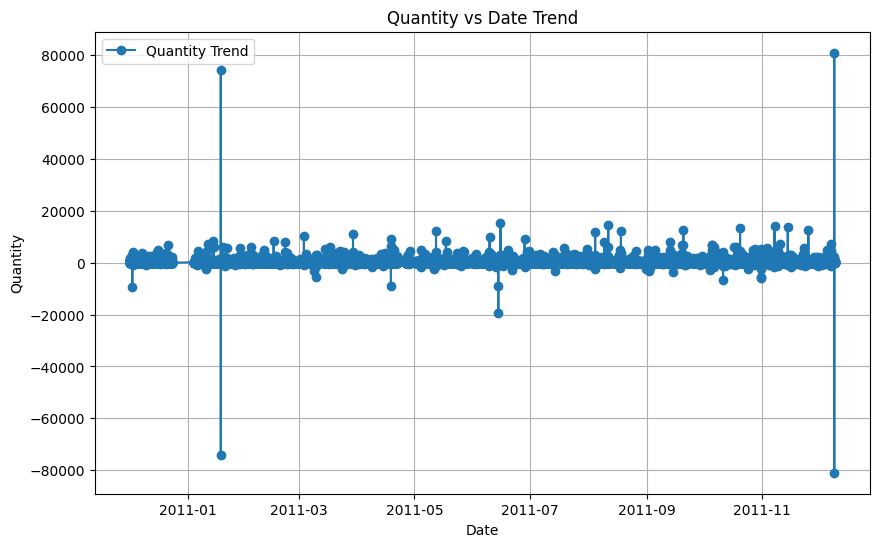

In [14]:
import matplotlib.pyplot as plt
# Convert the 'date' column to datetime type
df3['date'] = pd.to_datetime(df3['date'])

# Sort the DataFrame by date
df3 = df3.sort_values(by='date')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df3['date'], df3['qty'], marker='o', label='Quantity Trend')
plt.title('Quantity vs Date Trend')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
# identifying sales over time top 10
query="select (InvoiceDate) as date, sum(quantity) as qty from my_table group by 1 order by 2 desc limit 10"

df4 = pd.read_sql(query, conn)
df4

,date,qty
0,2011-12-09 09:15:00,80995
1,2011-01-18 10:01:00,74215
2,2011-06-15 13:37:00,15241
3,2011-08-11 16:12:00,14730
4,2011-11-07 17:42:00,14149
5,2011-11-14 17:55:00,13956
6,2011-10-20 12:03:00,13392
7,2011-09-20 11:05:00,12572
8,2011-11-25 15:57:00,12540
9,2011-05-12 10:13:00,12266


In [16]:
#Average Order Value
query= "select avg(value) from (select InvoiceNo, sum(UnitPrice*Quantity) as Value from my_table group by 1)"

df5 = pd.read_sql(query, conn)
df5

,avg(value)
0,376.360924


In [19]:
#MBA
query= "select ProductList, count(distinct InvoiceNo) from (SELECT InvoiceNo, GROUP_CONCAT(DISTINCT StockCode) AS ProductList, count(StockCode) as NoOfItems FROM (select InvoiceNo, StockCode from my_table group by InvoiceNo, StockCode Order by 1,2) GROUP BY InvoiceNo having NoOfItems>3) group by 1 order by 2 desc limit 10;"

df6=pd.read_sql(query, conn)
df6

,ProductList,count(distinct InvoiceNo)
0,"20914,21216,21218,21531,21533,21539,21843,2184...",5
1,"84997A,84997B,84997C,84997D",4
2,"23238,23240,23241,23242",4
3,"21931,22379,22385,85099B",4
4,"20969,20971,22147,22149,22273,22568,22569,22570",4
5,"20969,20970,20971,20972,21790,21888,21889,2191...",4
6,"84997A,84997C,84997D,POST",3
7,"23210,23211,23212,23213,POST",3
8,"23055,23056,23057,23071,23072,72802B,72802C",3
9,"23049,23050,23051,23052,23053,23054",3


In [18]:
# Frequency Of Purchases
query="select CustomerId, NoOfPurchases from (select CustomerID, count(distinct InvoiceNo) as NoOfPurchases from my_table group by 1 order by 2 desc limit 10) where CustomerId is NOT NULL"

df9=pd.read_sql(query, conn)
df9

,CustomerID,NoOfPurchases
0,14911.0,248
1,12748.0,224
2,17841.0,169
3,14606.0,128
4,15311.0,118
5,13089.0,118
6,12971.0,89
7,14527.0,86
8,13408.0,81
9,14646.0,77


In [20]:
# Average No of Purchases
query="select avg(NoOfPurchases) from (select CustomerID, NoOfPurchases from (select CustomerID, count(distinct InvoiceNo) as NoOfPurchases from my_table group by 1 order by 2 desc limit 10) where CustomerID IS NOT NULL)"

df7=pd.read_sql(query, conn)
df7

,avg(NoOfPurchases)
0,133.8


In [26]:
#Customer Lifetime Value
query="select avg(value) from(select CustomerID, Value from (select CustomerID, sum(Quantity*UnitPrice) as Value from my_table group by 1 order by 2 desc) where CustomerID IS NOT NULL)"

df8=pd.read_sql(query, conn)
df8

,avg(value)
0,1898.459701


In [22]:
# Sales Of UK
query="select country, sum(quantity) from my_table group by 1 having country='United Kingdom'"

df10=pd.read_sql(query, conn)
df10

,Country,sum(quantity)
0,United Kingdom,4008533


In [36]:
# Close the connection
conn.close()